In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

In [2]:
garstec_data = r'C:\Users\kiena\Documents\YEAR 4\PROJECT\Data\Garstec_AS09_chiara.hdf5'

# Open the hdf5 file (read-only mode)
with h5py.File(garstec_data, 'r') as hdf:

    # Navigate through Grid -> tracks -> track00001
    grid = hdf['grid']
    tracks = grid['tracks']
    track00001 = tracks['track00001']

    # Access effective temperature and luminosity as np arrays
    age_data = track00001['age'][:]
    teff_data = track00001['Teff'][:] 
    luminosity_data = track00001['LPhot'][:] 

age = age_data.reshape(-1, 1)
outputs = np.column_stack((luminosity_data, teff_data))

In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(age, outputs, test_size=0.2, random_state=1)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

# Convert to PyTorch tensors
X_train = torch.FloatTensor(scaler_x.fit_transform(X_train)).view(-1, 1)
X_test = torch.FloatTensor(scaler_x.transform(X_test)).view(-1, 1)
y_train = torch.FloatTensor(scaler_y.fit_transform(y_train))
y_test = torch.FloatTensor(scaler_y.transform(y_test))

In [4]:
# Define the neural network, all dense layers
class GarstecNet(nn.Module):
    def __init__(self):
        super(GarstecNet, self).__init__()
        self.dense1 = nn.Linear(1, 64)   # Input layer
        self.dense2 = nn.Linear(64, 32) # Hidden layer
        self.dense3 = nn.Linear(32, 2) # Output layer for luminosity and temperature
        

    def forward(self, x):
        x = torch.relu(self.dense1(x))
        x = torch.relu(self.dense2(x))
        x = self.dense3(x)
        return x
    
# Instantiate model, loss function, and optimizer
model = GarstecNet()
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.01)

Epoch [1000/10000], Train Loss: 0.0037, Test Loss: 0.0033
Epoch [2000/10000], Train Loss: 0.0037, Test Loss: 0.0033
Epoch [3000/10000], Train Loss: 0.0002, Test Loss: 0.0002
Epoch [4000/10000], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [5000/10000], Train Loss: 0.0022, Test Loss: 0.0016
Epoch [6000/10000], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [7000/10000], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [8000/10000], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [9000/10000], Train Loss: 0.0003, Test Loss: 0.0004
Epoch [10000/10000], Train Loss: 0.0000, Test Loss: 0.0000


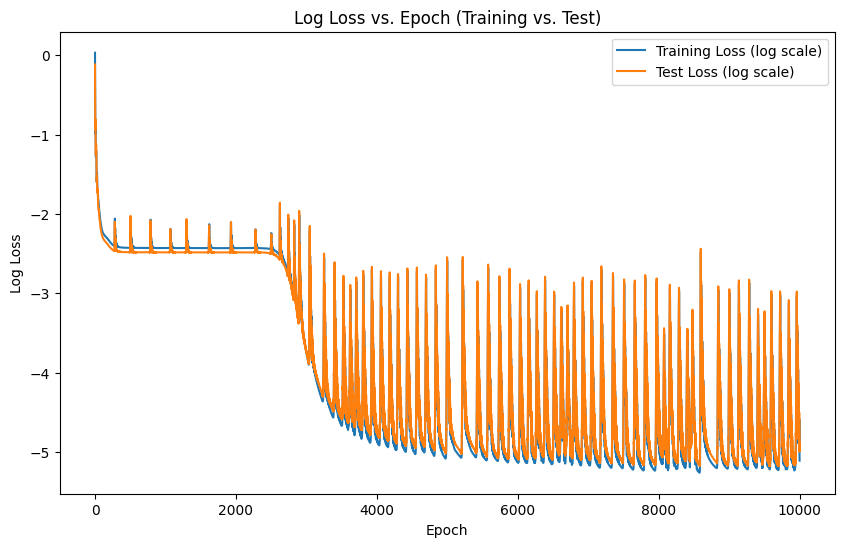

In [5]:
num_epochs = 10000
train_losses = []  # List to store training loss values at each epoch
test_losses = []   # List to store test loss values at each epoch

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    # Forward pass for training data
    outputs_train = model(X_train)
    train_loss = criterion(outputs_train, y_train)

    # Backward pass and optimization for training data
    optimizer.zero_grad()  # Clear gradients
    train_loss.backward()  # Backpropagation
    optimizer.step()       # Update weights

    # Forward pass for test data
    model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
    with torch.no_grad():
        outputs_test = model(X_test)
        test_loss = criterion(outputs_test, y_test)  # Calculate test loss
    
    # Store the losses for plotting
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

    # Print progress every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

# Plot training and test loss
plt.figure(figsize=(10, 6))
plt.plot(np.log10(train_losses), label='Training Loss (log scale)')
plt.plot(np.log10(test_losses), label='Test Loss (log scale)')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Log Loss vs. Epoch (Training vs. Test)')
plt.legend()
plt.show()

R^2 Score (Test Set): 1.0000
Mean Absolute Error (Test Set): 0.3719


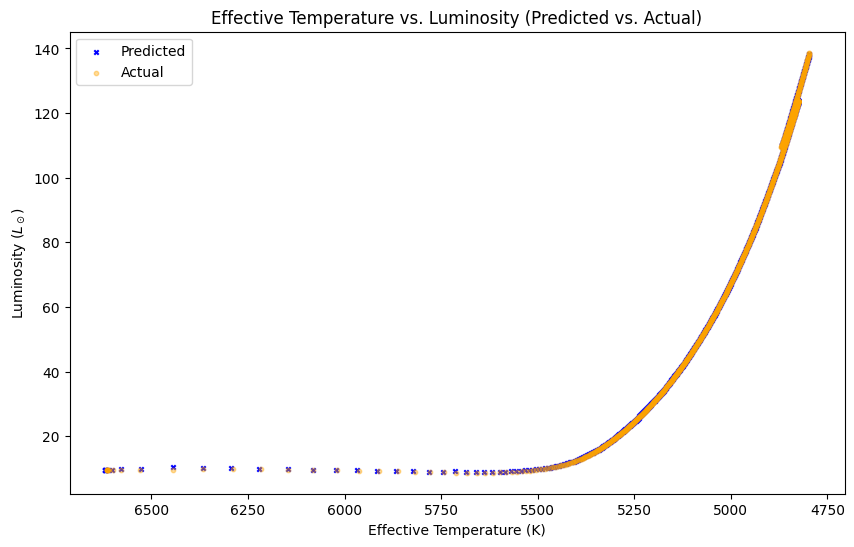

In [ ]:
model.eval()
with torch.no_grad():
    # Make predictions for both training and test sets
    predictions_train = model(X_train).numpy()
    predictions_train = scaler_y.inverse_transform(predictions_train)
    y_train_actual = scaler_y.inverse_transform(y_train.numpy())

    predictions_test = model(X_test).numpy()
    predictions_test = scaler_y.inverse_transform(predictions_test)
    y_test_actual = scaler_y.inverse_transform(y_test.numpy())

    
# Calculate metrics on the test set
r2 = r2_score(y_test_actual, predictions_test)
mae = mean_absolute_error(y_test_actual, predictions_test)
print(f'R^2 Score (Test Set): {r2:.4f}')
print(f'Mean Absolute Error (Test Set): {mae:.4f}')

predicted_luminosity_train = predictions_train[:, 0]
predicted_temperature_train = predictions_train[:, 1]
actual_luminosity_train = y_train_actual[:, 0]
actual_temperature_train = y_train_actual[:, 1]

predicted_luminosity_test = predictions_test[:, 0]
predicted_temperature_test = predictions_test[:, 1]
actual_luminosity_test = y_test_actual[:, 0]
actual_temperature_test = y_test_actual[:, 1]

# Plotting the combined data
plt.figure(figsize=(10, 6))
plt.scatter(predicted_temperature, predicted_luminosity, s=10, color='blue', marker='x', alpha=1, label='Predicted')
plt.scatter(actual_temperature, actual_luminosity, s=10, color='orange', alpha=0.4, label='Actual')
plt.gca().invert_xaxis()
plt.xlabel("Effective Temperature (K)")
plt.ylabel("Luminosity ($L_\odot$)")
plt.title("Effective Temperature vs. Luminosity (Predicted vs. Actual)")
plt.legend()
plt.show()